In [1]:
import os
import math
from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph
import pandas as pd
import jieba
import re
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
sns.set(style='white')
style.use("fivethirtyeight")

os.environ["CUDA_VISIBLE_DEVICES"] = '3' 

In [2]:
# pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset,DataLoader 
from torch.optim import Adam,SGD,RMSprop
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
from torch.nn.init import xavier_uniform_, kaiming_normal_
from torch.nn.parameter import Parameter
import time
import gc
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [3]:
from sklearn import metrics
from utils import * 
import pickle as pkl
datasets = ['mr','ohsumed','R8','R52','weibo_yiqing']
d = 'R8'
if d not in datasets:
    print("error dataset")
else:
    A, X, Y, _, _, _, _, _, _ = load_data(d)

In [4]:
print('loading total set')
A, M = preprocess_adj(A)
X = preprocess_features(X)
# print('loading validation set')
# val_adj, val_mask = preprocess_adj(val_adj)
# val_feature = preprocess_features(val_feature)
# print('loading test set')
# test_adj, test_mask = preprocess_adj(test_adj)
# test_feature = preprocess_features(test_feature)


  2%|▏         | 158/7674 [00:00<00:04, 1548.14it/s]

loading total set


100%|██████████| 7674/7674 [00:04<00:00, 1561.83it/s]


In [5]:
total_samples = X.shape[0]
total_samples

7674

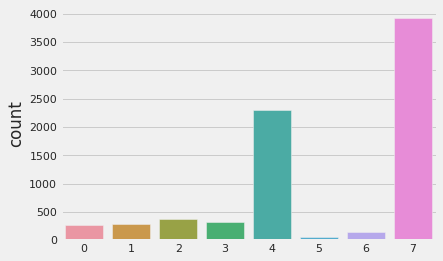

In [6]:
Y = np.where(Y)[1]
sns.countplot(Y)

In [7]:
A.shape,X.shape,Y.shape

((7674, 291, 291), (7674, 291, 300), (7674,))

In [8]:
Y

array([3, 4, 7, ..., 7, 7, 4])

In [9]:
train_adj = torch.Tensor(A[:int(0.8 * total_samples)])
train_feature = torch.Tensor(X[:int(0.8 * total_samples)])
train_y = torch.LongTensor(Y[:int(0.8 * total_samples)])

val_adj = torch.Tensor(A[int(0.8 * total_samples):int(0.9 * total_samples)])
val_feature = torch.Tensor(X[int(0.8 * total_samples):int(0.9 * total_samples)])
val_y = torch.LongTensor(Y[int(0.8 * total_samples):int(0.9 * total_samples)])

test_adj = torch.Tensor(A[int(0.9 * total_samples):])
test_feature = torch.Tensor(X[int(0.9 * total_samples):])
test_y = torch.LongTensor(Y[int(0.9 * total_samples):])

train_mask = torch.Tensor(M[:int(0.8 * total_samples)])
val_mask =torch.Tensor(M[int(0.8 * total_samples):int(0.9 * total_samples)])
test_mask =torch.Tensor(M[int(0.9 * total_samples):])

In [10]:
train_adj.shape,train_feature.shape,train_y.shape

(torch.Size([6139, 291, 291]),
 torch.Size([6139, 291, 300]),
 torch.Size([6139]))

In [11]:
val_adj.shape,val_feature.shape,val_y.shape

(torch.Size([767, 291, 291]), torch.Size([767, 291, 300]), torch.Size([767]))

In [12]:
test_adj.shape,test_feature.shape,test_y.shape

(torch.Size([768, 291, 291]), torch.Size([768, 291, 300]), torch.Size([768]))

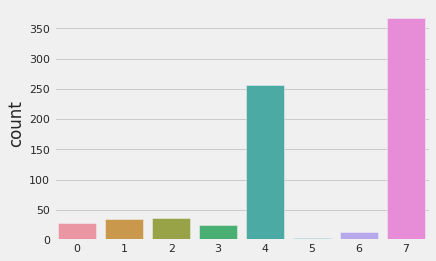

In [13]:
sns.countplot(test_y.numpy())

In [14]:
# split mini-batch
def getBatch(i, bs, A, X, Y,mask):
    return A[i*bs:(i+1)*bs],X[i*bs:(i+1)*bs],Y[i*bs:(i+1)*bs],mask[i*bs:(i+1)*bs]

In [15]:
# parameters
lr = 0.01
batch_size = 32
epochs = 200
weight_decay = 0.

num_class = 8
train_samples = train_y.shape[0]
test_samples = test_y.shape[0]
val_samples = val_y.shape[0]

In [16]:
# GFM-GC model 
from layers import GraphConvolution
from torch.nn.init import xavier_uniform_, kaiming_normal_
class GFMGC(nn.Module):
    def __init__(self, num_class, input_dim, fb_size):
        super(GFMGC,self).__init__()
        
        self.num_class = num_class
        self.input_dim = input_dim
#         self.W = nn.Parameter(torch.FloatTensor(input_dim, fb_size))
        
        self.gru = nn.GRU(self.input_dim,
                          128,
                          bidirectional = True,
                          batch_first = True,
                          bias = True)
    
        self.fc1 = nn.Sequential(nn.Linear(300 + 128 * 2,128),
                                 nn.ReLU(inplace = True),
                                 nn.BatchNorm1d(128),
                                 nn.Linear(128,64),
                                 nn.ReLU(inplace = True),
                                 nn.BatchNorm1d(64),
                                 nn.Linear(64,num_class),
                                 
                                 
            )
        self._init_weights()
    
    def cal_gfm(self,x,adj,bs,seq,emb):# x-[bs,seq,emb_size]  adj:[bs,seq,seq]

        left = x.repeat(1,1,seq).view(bs,seq * seq ,emb)
        right = x.repeat(1,seq,1)
        fi = left * right   
        adj = adj.view(bs,seq*seq).unsqueeze(2)
        return torch.sum(fi * adj,dim = 1)
                                                                              
    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                kaiming_normal_(p)
        
    def forward(self,x,adj,mask):# x:[bs,seq,emb_size]  adj:[bs,seq,seq]
        x = x * mask
        bs, seq, emb = x.shape
        print(bs,seq,emb)
        h = self.gru(x)[0][:,-1,:]
#         print(h.shape)
        gfm = self.cal_gfm(x,adj,bs,seq,emb)
#         gfm = F.dropout(gfm,0.1,training = self.training)
        logit = self.fc1(torch.cat([h,gfm],dim=1))
        return logit

In [17]:
model = GFMGC(num_class = num_class, input_dim = 300,fb_size=100).cuda()

optimizer = Adam(model.parameters(),lr = lr,weight_decay = weight_decay)
lossfunc = nn.CrossEntropyLoss()

In [18]:
def train():
    best_acc = 0.0
    for epoch in range(epochs):
        model.train() 
        print('epoch {}'.format(epoch + 1))
        train_loss = []
        train_acc = 0.
        for i in tqdm(range(train_samples // batch_size + 1)):
            adj_batch,feature_batch, y_batch, mask_batch = getBatch(i, batch_size, train_adj, train_feature, train_y,train_mask)
            optimizer.zero_grad()
            logits = model(feature_batch.cuda(),adj_batch.cuda(),mask_batch.cuda())
            loss = lossfunc(logits, y_batch.cuda())
            
            train_loss.append(loss.item())
            
            pred = torch.max(logits,1)[1]
            
            train_correct = (pred.cpu()  == y_batch).sum()
            
            train_acc += train_correct
            
            loss.backward()
            optimizer.step()
            
        print('train_loss = {:0.4f}, train_acc = {:0.4f}'.format(np.mean(train_loss), train_acc / train_samples))
        
        model.eval()
        
        val_loss = []
        val_acc = 0.
        with torch.no_grad():
            for i in tqdm(range(test_samples // batch_size + 1)):
                adj_batch,feature_batch, y_batch, mask_batch = getBatch(i, batch_size, test_adj, test_feature, test_y,test_mask)
                logits = model(feature_batch.cuda(),adj_batch.cuda(),mask_batch.cuda())
                loss = lossfunc(logits, y_batch.cuda())
                val_loss.append(loss.item())
                pred = torch.max(logits,1)[1]
                val_correct = (pred.cpu() == y_batch).sum()

                val_acc += val_correct
            # best_acc
            if best_acc < val_acc / test_samples:
                best_acc = val_acc / test_samples
            print('test_loss = {:0.4f},  test_acc = {:0.4f}, best_acc = {:0.4f}'.format(np.mean(val_loss), val_acc / test_samples,\
                                                                                     best_acc))

In [ ]:
train()

  1%|          | 1/192 [00:00<00:26,  7.22it/s]

epoch 1
32 291 300
32 291 300


  2%|▏         | 4/192 [00:00<00:22,  8.40it/s]

32 291 300
32 291 300
32 291 300


  3%|▎         | 6/192 [00:00<00:20,  8.97it/s]

32 291 300
32 291 300
32 291 300


  5%|▌         | 10/192 [00:01<00:18,  9.58it/s]

32 291 300
32 291 300
32 291 300


  6%|▋         | 12/192 [00:01<00:18,  9.81it/s]

32 291 300
32 291 300
32 291 300


  8%|▊         | 15/192 [00:01<00:17, 10.06it/s]

32 291 300
32 291 300


  9%|▉         | 17/192 [00:01<00:18,  9.40it/s]

32 291 300
32 291 300


 10%|█         | 20/192 [00:02<00:17,  9.72it/s]

32 291 300
32 291 300


 11%|█▏        | 22/192 [00:02<00:17,  9.79it/s]

32 291 300
32 291 300
32 

 12%|█▏        | 23/192 [00:02<00:17,  9.60it/s]

291 300
32 291 300


 14%|█▎        | 26/192 [00:02<00:17,  9.74it/s]

32 291 300
32 291 300


 14%|█▍        | 27/192 [00:02<00:17,  9.33it/s]

32 291 300
32 291 300


 15%|█▌        | 29/192 [00:02<00:17,  9.28it/s]

32 291 300
32 291 300


 16%|█▌        | 31/192 [00:03<00:18,  8.86it/s]

32 291 300
32 291 300


 17%|█▋        | 33/192 [00:03<00:17,  8.86it/s]

32 291 300
32 291 300


 18%|█▊        | 35/192 [00:03<00:20,  7.81it/s]

32 291 300
32 291 300


 19%|█▉        | 37/192 [00:04<00:22,  7.00it/s]

32 291 300
32 291 300


 20%|██        | 39/192 [00:04<00:21,  7.06it/s]

32 291 300
32 291 300


 21%|██▏       | 41/192 [00:04<00:23,  6.51it/s]

32 291 300
32 291 300


 22%|██▏       | 43/192 [00:04<00:20,  7.19it/s]

32 291 300
32 291 300


 23%|██▎       | 45/192 [00:05<00:20,  7.20it/s]

32 291 300
32 291 300


 24%|██▍       | 47/192 [00:05<00:19,  7.27it/s]

32 291 300
32 291 300


 26%|██▌       | 49/192 [00:05<00:21,  6.72it/s]

32 291 300
32 291 300


 27%|██▋       | 51/192 [00:06<00:22,  6.41it/s]

32 291 300
32 291 300


 28%|██▊       | 53/192 [00:06<00:20,  6.63it/s]

32 291 300
32 291 300


 29%|██▊       | 55/192 [00:06<00:19,  6.89it/s]

32 291 300
32 291 300


 30%|██▉       | 57/192 [00:06<00:19,  6.80it/s]

32 291 300
32 291 300


 31%|███       | 59/192 [00:07<00:19,  6.87it/s]

32 291 300
32 291 300


 32%|███▏      | 61/192 [00:07<00:16,  7.71it/s]

32 291 300
32 291 300


 33%|███▎      | 63/192 [00:07<00:18,  6.82it/s]

32 291 300
32 291 300


 34%|███▍      | 65/192 [00:08<00:18,  6.93it/s]

32 291 300
32 291 300


 35%|███▍      | 67/192 [00:08<00:19,  6.52it/s]

32 291 300
32 291 300


 36%|███▌      | 69/192 [00:08<00:18,  6.54it/s]

32 291 300
32 291 300


 37%|███▋      | 71/192 [00:09<00:19,  6.28it/s]

32 291 300
32 291 300


 38%|███▊      | 73/192 [00:09<00:17,  6.81it/s]

32 291 300
32 291 300


 39%|███▉      | 75/192 [00:09<00:17,  6.53it/s]

32 291 300
32 291 300


 40%|████      | 77/192 [00:09<00:17,  6.53it/s]

32 291 300
32 291 300


 41%|████      | 79/192 [00:10<00:17,  6.34it/s]

32 291 300
32 291 300


 42%|████▏     | 81/192 [00:10<00:15,  7.02it/s]

32 291 300
32 291 300


 43%|████▎     | 83/192 [00:10<00:16,  6.70it/s]

32 291 300
32 291 300


 44%|████▍     | 85/192 [00:11<00:16,  6.60it/s]

32 291 300
32 291 300


 45%|████▌     | 87/192 [00:11<00:16,  6.29it/s]

32 291 300
32 291 300


 46%|████▋     | 89/192 [00:11<00:16,  6.40it/s]

32 291 300
32 291 300


 47%|████▋     | 91/192 [00:12<00:15,  6.48it/s]

32 291 300
32 291 300


 48%|████▊     | 93/192 [00:12<00:15,  6.47it/s]

32 291 300
32 291 300


 49%|████▉     | 95/192 [00:12<00:14,  6.50it/s]

32 291 300
32 291 300


 51%|█████     | 97/192 [00:12<00:14,  6.76it/s]

32 291 300
32 291 300


 52%|█████▏    | 99/192 [00:13<00:14,  6.47it/s]

32 291 300
32 291 300


 53%|█████▎    | 101/192 [00:13<00:13,  6.51it/s]

32 291 300
32 291 300


 54%|█████▎    | 103/192 [00:13<00:14,  6.04it/s]

32 291 300
32 291 300


 55%|█████▍    | 105/192 [00:14<00:14,  6.14it/s]

32 291 300
32 291 300


 56%|█████▌    | 107/192 [00:14<00:14,  5.85it/s]

32 291 300
32 291 300


 57%|█████▋    | 109/192 [00:14<00:13,  6.27it/s]

32 291 300
32 291 300


 58%|█████▊    | 111/192 [00:15<00:12,  6.33it/s]

32 291 300
32 291 300


 59%|█████▉    | 113/192 [00:15<00:12,  6.14it/s]

32 291 300
32 291 300


 60%|█████▉    | 115/192 [00:15<00:12,  6.22it/s]

32 291 300
32 291 300


 61%|██████    | 117/192 [00:16<00:11,  6.34it/s]

32 291 300
32 291 300


 62%|██████▏   | 119/192 [00:16<00:11,  6.24it/s]

32 291 300
32 291 300


 63%|██████▎   | 121/192 [00:16<00:10,  6.57it/s]

32 291 300
32 291 300


 64%|██████▍   | 123/192 [00:17<00:10,  6.69it/s]

32 291 300
32 291 300


 65%|██████▌   | 125/192 [00:17<00:10,  6.27it/s]

32 291 300
32 291 300


 66%|██████▌   | 127/192 [00:17<00:10,  6.37it/s]

32 291 300
32 291 300


 67%|██████▋   | 129/192 [00:18<00:09,  6.69it/s]

32 291 300
32 291 300


 68%|██████▊   | 131/192 [00:18<00:09,  6.70it/s]

32 291 300
32 291 300


 69%|██████▉   | 133/192 [00:18<00:08,  6.81it/s]

32 291 300
32 291 300


 70%|███████   | 135/192 [00:18<00:08,  6.62it/s]

32 291 300
32 291 300


 71%|███████▏  | 137/192 [00:19<00:08,  6.86it/s]

32 291 300
32 291 300


 72%|███████▏  | 139/192 [00:19<00:08,  6.61it/s]

32 291 300
32 291 300


 73%|███████▎  | 141/192 [00:19<00:07,  6.88it/s]

32 291 300
32 291 300


 74%|███████▍  | 143/192 [00:20<00:07,  6.38it/s]

32 291 300
32 291 300


 76%|███████▌  | 145/192 [00:20<00:06,  6.97it/s]

32 291 300
32 291 300


 77%|███████▋  | 147/192 [00:20<00:06,  6.71it/s]

32 291 300
32 291 300


 78%|███████▊  | 149/192 [00:21<00:06,  6.55it/s]

32 291 300
32 291 300


 79%|███████▊  | 151/192 [00:21<00:06,  6.47it/s]

32 291 300
32 291 300


 80%|███████▉  | 153/192 [00:21<00:05,  6.55it/s]

32 291 300
32 291 300


 81%|████████  | 155/192 [00:21<00:06,  6.04it/s]

32 291 300
32 291 300


 82%|████████▏ | 157/192 [00:22<00:05,  6.33it/s]

32 291 300
32 291 300


 83%|████████▎ | 159/192 [00:22<00:04,  6.62it/s]

32 291 300
32 291 300


 84%|████████▍ | 161/192 [00:22<00:04,  6.82it/s]

32 291 300
32 291 300


 85%|████████▍ | 163/192 [00:23<00:04,  6.68it/s]

32 291 300
32 291 300


 86%|████████▌ | 165/192 [00:23<00:04,  6.74it/s]

32 291 300
32 291 300


 87%|████████▋ | 167/192 [00:23<00:03,  7.03it/s]

32 291 300
32 291 300


 88%|████████▊ | 169/192 [00:24<00:03,  6.62it/s]

32 291 300
32 291 300


 89%|████████▉ | 171/192 [00:24<00:03,  6.44it/s]

32 291 300
32 291 300


 90%|█████████ | 173/192 [00:24<00:02,  6.51it/s]

32 291 300
32 291 300


 91%|█████████ | 175/192 [00:24<00:02,  6.79it/s]

32 291 300
32 291 300


 92%|█████████▏| 177/192 [00:25<00:02,  6.62it/s]

32 291 300
32 291 300


 93%|█████████▎| 179/192 [00:25<00:01,  6.54it/s]

32 291 300
32 291 300


 94%|█████████▍| 181/192 [00:25<00:01,  6.56it/s]

32 291 300
32 291 300


 95%|█████████▌| 183/192 [00:26<00:01,  6.37it/s]

32 291 300
32 291 300


 96%|█████████▋| 185/192 [00:26<00:01,  6.46it/s]

32 291 300
32 291 300


 97%|█████████▋| 187/192 [00:26<00:00,  6.24it/s]

32 291 300
32 291 300


 98%|█████████▊| 189/192 [00:27<00:00,  6.21it/s]

32 291 300
32 291 300


 99%|█████████▉| 191/192 [00:27<00:00,  5.91it/s]

32 291 300
27 291 300


  4%|▍         | 1/25 [00:00<00:02,  9.21it/s]

train_loss = 0.4777, train_acc = 0.8521
32 291 300
32 291 300


 12%|█▏        | 3/25 [00:00<00:02,  9.03it/s]

32 291 300
32 291 300


 20%|██        | 5/25 [00:00<00:02,  8.88it/s]

32 291 300
32 291 300


 28%|██▊       | 7/25 [00:00<00:02,  8.77it/s]

32 291 300
32 291 300


 36%|███▌      | 9/25 [00:01<00:02,  7.90it/s]

32 291 300
32 291 300


 44%|████▍     | 11/25 [00:01<00:01,  8.29it/s]

32 291 300
32 291 300


 52%|█████▏    | 13/25 [00:01<00:01,  7.46it/s]

32 291 300
32 291 300


 60%|██████    | 15/25 [00:01<00:01,  7.15it/s]

32 291 300
32 291 300


 68%|██████▊   | 17/25 [00:02<00:01,  7.74it/s]

32 291 300
32 291 300


 76%|███████▌  | 19/25 [00:02<00:00,  7.35it/s]

32 291 300
32 291 300


 84%|████████▍ | 21/25 [00:02<00:00,  7.36it/s]

32 291 300
32 291 300


 92%|█████████▏| 23/25 [00:02<00:00,  6.77it/s]

32 291 300
32 291 300


 96%|█████████▌| 24/25 [00:03<00:00,  6.92it/s]